In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
#from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8339733954552154509
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4133486592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7762294654368041772
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:26:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [7]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# -------------------------------------
# 2. CONFIGURACIÓN
# -------------------------------------

In [3]:
mixed_precision.set_global_policy('mixed_float16')

# Parámetros
img_size = (224, 224)
batch_size = 32
epochs = 100
seed = 123
train_dir = '../dataset/multi-6/train'
model_path = 'mobilenetv2_derma_v1.keras'

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


# -------------------------------------
# 3. DATA AUGMENTATION Y GENERADORES
# -------------------------------------

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
# Obtener número de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

#Imprimir dataset
for x, y in train_ds.take(5):
    print("Imagen shape:", x.shape)
    print("Etiqueta:", y.numpy())


Found 30901 files belonging to 6 classes.
Using 24721 files for training.
Found 30901 files belonging to 6 classes.
Using 6180 files for validation.
Clases: ['Acne', 'Benign', 'Eczema', 'Infectious', 'Malign', 'Pigmentation']
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 3 1 1 3 0 4 2 2 1 3 1 1 5 1 3 4 1 1 1 3 1 1 1 1 2 1 2 3 1 0]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 5 1 1 1 4 3 1 0 3 1 4 1 3 4 4 1 2 1 5 4 4 4 3 1 2 0 4 1 1 4]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 0 0 4 1 3 1 4 1 3 3 4 5 4 3 4 2 4 1 4 3 4 4 1 4 4 1 3 3 3 1 1]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 3 1 1 1 1 1 1 4 0 3 4 1 2 3 1 1 5 2 1 4 2 3 3 4 4 2 2 1 1 1 2]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [2 4 1 1 2 3 3 3 4 3 1 0 1 1 3 5 3 5 2 4 2 1 3 1 1 0 0 4 3 4 1 0]


In [13]:

# ---------------------------------------
# CÁLCULO DE PESOS POR CLASE
# ---------------------------------------
from sklearn.utils.class_weight import compute_class_weight

# Contar imágenes por clase
image_counts = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    image_counts.append(count)

# Crear vector de etiquetas reales
y_train = []
for i, count in enumerate(image_counts):
    y_train += [i] * count
y_train = np.array(y_train)

# Calcular pesos
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(weights))

print("Pesos por clase:", class_weight)

Pesos por clase: {0: 2.396618582286335, 1: 0.4733762254901961, 2: 1.2654381654381655, 3: 0.8583888888888889, 4: 0.7593002113125952, 5: 5.049346405228758}


In [14]:
# ----------------------------
# PENALIZACIÓN EN CLASES CON MAYOR RIESGO
# ----------------------------

high_danger = {4}

moderate_danger = {2, 3}

low_danger = set(range(num_classes)) - high_danger - moderate_danger

cost_matrix = tf.ones([num_classes, num_classes])           # baseline cost = 1

cost_matrix = tf.where(tf.eye(num_classes) == 1, 0., cost_matrix)     # zero on the diagonal

# Penalizes False Negatives for the high and moderate danger

for high in high_danger:
    for low in low_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[high, low]],
                                        updates=[10.0]) 
        
    for mid in moderate_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[high, mid]],
                                        updates=[5.0]) 
        
for mid in moderate_danger:
    for low in low_danger:
        cost_matrix = tf.tensor_scatter_nd_update(cost_matrix,
                                        indices=[[mid, low]],
                                        updates=[5.0])
        
print(cost_matrix)


tf.Tensor(
[[ 0.  1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.  1.]
 [ 5.  5.  0.  1.  1.  5.]
 [ 5.  5.  1.  0.  1.  5.]
 [10. 10.  5.  5.  0. 10.]
 [ 1.  1.  1.  1.  1.  0.]], shape=(6, 6), dtype=float32)


In [15]:
def cost_matrix_sparse_categorical_crossentropy_loss(y_true, y_pred, alpha=1.0, debug=False):
    if y_true.dtype.is_integer:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

    # The cost of this prediction, using the row of the matrix
    row_cost = tf.matmul(y_true, cost_matrix) 
    if debug:
        print(row_cost)
    # Sums all the costs, 0s and the cost of the true prediction, multiplied by the 
    exp_cost = tf.reduce_sum(row_cost * y_pred, axis=-1)
    if debug:
        print(exp_cost)

    y_pred = tf.nn.softmax(y_pred)
    cross_entro = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return cross_entro + alpha * exp_cost
    

In [16]:
y_true = tf.convert_to_tensor([[0.,0.,0.,0.,1.,0.]], dtype=tf.float32)
print(y_true.ndim)
y_pred = tf.convert_to_tensor([[0.2,0.2,0.,0.,0.47,0.13]], dtype=tf.float32)
print(y_pred.ndim)
loss = cost_matrix_sparse_categorical_crossentropy_loss(y_true, y_pred, debug=True)
print(loss)


2
2
tf.Tensor([[10. 10.  5.  5.  0. 10.]], shape=(1, 6), dtype=float32)
tf.Tensor([5.3], shape=(1,), dtype=float32)
tf.Tensor([6.801526], shape=(1,), dtype=float32)


In [17]:
# Optimización de rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Configuración de caché y prefetch
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [18]:
# Modelo base (preentrenado)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # congelamos capas base

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.GaussianNoise(0.2)
])


# Modelo completo (sin preprocessing dentro)
model = models.Sequential([
    base_model,
    data_augmentation,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 [==============================] - 0s 0us/step


In [19]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight 
)

Epoch 1/100


C:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/sequential/random_rotation/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 7, 7, 1280), dtype=float16), dense_shape=Tensor("gradient_tape/sequential_1/sequential/random_rotation/loop_body/GatherV2/pfor/Cast:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


773/773 [==============================] - 215s 268ms/step - loss: 1.4062 - accuracy: 0.4304 - val_loss: 1.2661 - val_accuracy: 0.4951
Epoch 2/100
773/773 [==============================] - 193s 249ms/step - loss: 1.2730 - accuracy: 0.4802 - val_loss: 1.2125 - val_accuracy: 0.5081
Epoch 3/100
773/773 [==============================] - 192s 249ms/step - loss: 1.2287 - accuracy: 0.5001 - val_loss: 1.2272 - val_accuracy: 0.4867
Epoch 4/100
773/773 [==============================] - 193s 250ms/step - loss: 1.1906 - accuracy: 0.5161 - val_loss: 1.1381 - val_accuracy: 0.5372
Epoch 5/100
773/773 [==============================] - 191s 247ms/step - loss: 1.1596 - accuracy: 0.5306 - val_loss: 1.1331 - val_accuracy: 0.5455
Epoch 6/100
773/773 [==============================] - 206s 267ms/step - loss: 1.1314 - accuracy: 0.5414 - val_loss: 1.1202 - val_accuracy: 0.5553
Epoch 7/100
773/773 [==============================] - 198s 256ms/step - loss: 1.1146 - accuracy: 0.5438 - val_loss: 1.0943 - val_

Found 30901 files belonging to 6 classes.
966/966 [==============================] - 33s 31ms/step
🧾 Clasification Report:

              precision    recall  f1-score   support

        Acne       0.63      0.75      0.68      2148
      Benign       0.80      0.68      0.73     10880
      Eczema       0.63      0.62      0.62      4070
  Infectious       0.51      0.69      0.59      6000
      Malign       0.71      0.63      0.67      6783
Pigmentation       0.69      0.63      0.66      1020

    accuracy                           0.67     30901
   macro avg       0.66      0.67      0.66     30901
weighted avg       0.69      0.67      0.67     30901



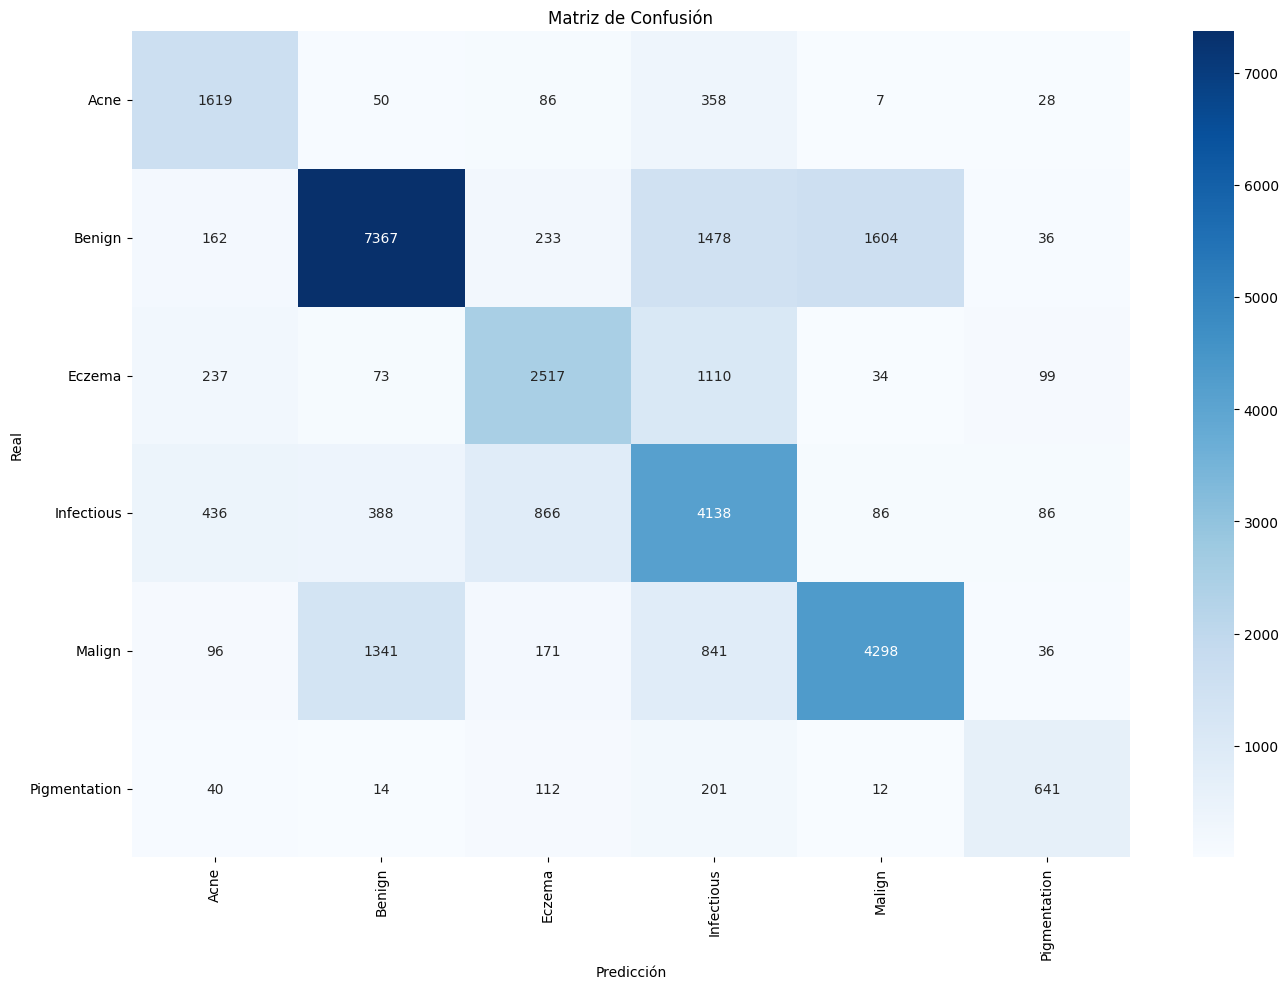

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Rutas
test_dir = '../dataset/multi-6/train'

# Cargar modelo entrenado
model = tf.keras.models.load_model(model_path)

# Cargar dataset de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False  # MUY IMPORTANTE para alinear predicciones con etiquetas
)

# Obtener nombres de clase
class_names = test_ds.class_names
num_classes = len(class_names)

# Prefetch para acelerar
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Obtener predicciones
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas reales
y_true = np.concatenate([y.numpy() for x, y in test_ds])

# Reporte de clasificación
print("🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
